## Preambule

In [15]:
# General packages
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import xarray as xr
import json

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors

## Parameter

In [16]:
hist_startyear = 1990
rules = ['GF', 'PC', 'PCC', 'ECPC', 'AP', 'GDR']

## Paths

In [17]:
path_main = Path("X:/user/dekkerm/Projects/ECEMF_T5.2/")
path_data = path_main / "Data" / str(hist_startyear)
path_figs = path_main / "Figures"

## Read data files

In [18]:
xr_total = xr.open_dataset(path_data / "xr_total.nc")
all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.load(path_data / "all_regions_names.npy")
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)
only_regions_iso = ['CVF', 'G20', "EU", "G7", "NA", "AU", "AF", "SIDS", "LDC", "WORLD"]
only_regions_names = ['Climate Vulnerability Forum','G20',"European Union","G7","Northern America","Australasia","African Group","Small Island Developing States","Least Developed Countries"]

In [19]:
xr_budgets_static = xr.open_dataset(path_data / "xr_budgets_static.nc")
xr_budgets_linear = xr.open_dataset(path_data / "xr_budgets_linear.nc")
xr_budgets_scenario = xr.open_dataset(path_data / "xr_budgets_scenario.nc")
df_michel = pd.read_excel(Path("X:/user/dekkerm/Data/") / "NDC" / "NDC_comparison.xlsx", sheet_name="Michel")

In [20]:
factor_lulucf = float(np.mean(xr_total.GHG_f_incl.sel(Time=2030)/xr_total.GHG_f.sel(Time=2030)))

In [21]:
df = pd.read_excel(Path("X:/user/dekkerm/Data/") / "UNFCCC_Parties_Groups_noeu.xlsx", sheet_name = "Country groups")
countries_iso = np.array(df["Country ISO Code"])
group_cvf = countries_iso[np.array(df["CVF (24/10/22)"]) == 1]
group_g20 = countries_iso[np.array(df["G20"]) == 1]
group_eu = countries_iso[np.array(df["EU"]) == 1]
group_g7 = countries_iso[np.array(df["G7"]) == 1]
group_na = countries_iso[np.array(df["Northern America"]) == 1]
group_um = countries_iso[np.array(df["Umbrella"]) == 1]
group_au = countries_iso[np.array(df["Australasia"]) == 1]
group_af = countries_iso[np.array(df["African Group"]) == 1]
group_sids = countries_iso[np.array(df["SIDS"]) == 1]
group_ldc = countries_iso[np.array(df["LDC"]) == 1]
group_eg = countries_iso[np.array(df["European Group"]) == 1]

In [22]:
df = pd.read_csv(Path("X:/user/dekkerm/Data/") / "AllCountries.csv")
cont_iso = np.array(df['alpha-3']).astype(str)
cont_reg = np.array(df['sub-region']).astype(str)
unireg = np.unique(cont_reg)[:-1]

## Derive relationship between cumulative GHG and temperature assessment

In [23]:
df_ar6_meta = pd.read_excel("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name='meta_Ch3vetted_withclimate')
df_ar6_data = pd.read_csv("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_World_v1.1.csv")

In [24]:
mods = np.array(df_ar6_meta.Model)
scens = np.array(df_ar6_meta.Scenario)
modscens_meta = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_meta['ModelScenario'] = modscens_meta
modcat = np.array([np.array(df_ar6_meta.ModelScenario), np.array(df_ar6_meta.Category)])
mods = np.array(df_ar6_data.Model)
scens = np.array(df_ar6_data.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_data['ModelScenario'] = modscens

In [25]:
df_ar6_new = df_ar6_data[df_ar6_data.Variable.isin(['Emissions|CO2',
                                                    'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile',
                                                    'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|5.0th Percentile',
                                                    'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile',
                                                    "Emissions|Kyoto Gases"
                                                    ])][['ModelScenario', 'Variable']+list(np.arange(2020, 2101).astype(str))]
df_ar6_new = df_ar6_new.reset_index(drop=True)
df_ar6_new = df_ar6_new.melt(id_vars = ["ModelScenario", 'Variable'], var_name='Time', value_name='Value')
df_ar6_new['Time'] = df_ar6_new['Time'].astype(int)
df_dummy = df_ar6_new.set_index(['ModelScenario', 'Variable', "Time"])
xr_ar6_new = xr.Dataset.from_dataframe(df_dummy)
xr_ar6_new = xr_ar6_new.reindex(Time = np.arange(2020, 2101))
xr_ar6_new = xr_ar6_new.interpolate_na(dim="Time", method="linear")

x:\user\dekkerm\environments\MyEnv\lib\site-packages\xarray\core\missing.py:264: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:


In [26]:
modscens = np.array(xr_ar6_new.ModelScenario)
temperatures = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile", Time=2100).Value)
temperatures5 = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|5.0th Percentile", Time=2100).Value)
temperatures95 = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile", Time=2100).Value)
ghg_2030 = np.array(xr_ar6_new.sel(Variable = "Emissions|Kyoto Gases", Time=2030).Value)

# Remove nans
nonans_temp = np.where(~np.isnan(temperatures))[0]
nonans_ghg = np.where(~np.isnan(ghg_2030))[0]
nonans = np.intersect1d(nonans_temp, nonans_ghg)
modscens = modscens[nonans]
temperatures = temperatures[nonans]
temperatures5 = temperatures5[nonans]
temperatures95 = temperatures95[nonans]
ghg_2030 = ghg_2030[nonans]

# Remove zeros
nozero_ghg = np.where(ghg_2030 > 0)[0]
modscens = modscens[nozero_ghg]
temperatures = temperatures[nozero_ghg]
temperatures5 = temperatures5[nozero_ghg]
temperatures95 = temperatures95[nozero_ghg]
ghg_2030 = ghg_2030[nozero_ghg]/factor_lulucf

# Linear regression
k = 3
coef_ghg_2030 = np.polyfit(ghg_2030, temperatures, k)

GF USA 0.12879119799959096
GF CHN 0.26628051970694333
GF EU 0.07716748222501402
PC USA 0.04148390624528287
PC CHN 0.16729675420899745
PC EU 0.05241650133458042
AP USA 0.09482012200847663
AP CHN 0.2832998024917101
AP EU 0.053042157309826
GDR USA 0.05298710059133865
GDR CHN 0.32514205238273086
GDR EU 0.04234996052871953


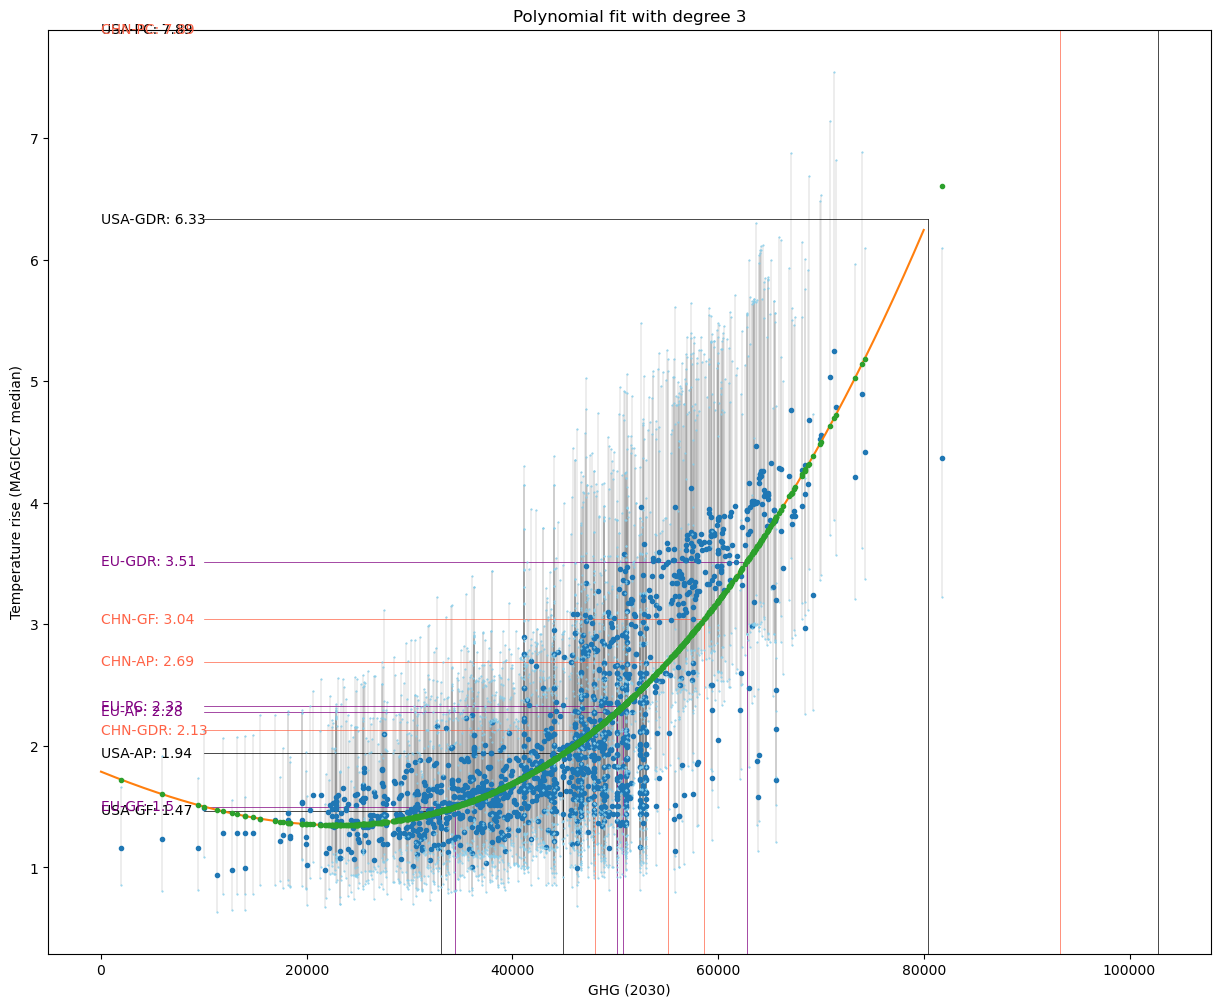

In [27]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(ghg_2030, temperatures, '.')
ax.plot(ghg_2030, temperatures5, '.', c='skyblue', ms=1)
ax.plot(ghg_2030, temperatures95, '.', c='skyblue', ms=1)
for i in range(len(ghg_2030)):
    ax.plot([ghg_2030[i], ghg_2030[i]], [temperatures5[i], temperatures95[i]], 'grey', lw=0.2, zorder=-1e9)
ax.set_ylim(ax.get_ylim())
ax.plot(np.arange(1, 80000., 10), np.sum([np.arange(1, 80000., 10)**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0), '-')
ax.plot(ghg_2030, np.sum([ghg_2030**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0), '.')
for var in ['GF', 'PC', 'AP', 'GDR']:
    for cty_i, cty in enumerate(['USA', 'CHN', 'EU']):
        perc = np.array(xr_budgets_scenario.sel(Time=2030, ISO=cty)[var] / xr_budgets_scenario.sel(Time=2030, ISO='WORLD')["GF"]).mean()
        print(var, cty, perc)
        ndc = float((xr_total.sel(ISO=cty, Time=2030).NDC_h+xr_total.sel(ISO=cty, Time=2030).NDC_l)/2)*1e3
        ndc_globalversion = ndc/perc
        inters = np.max([np.min([np.sum([ndc_globalversion**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0), ax.get_ylim()[1]]), ax.get_ylim()[0]])
        ax.plot([ndc_globalversion, ndc_globalversion], [-1e3, inters], c=['k', 'tomato', 'purple'][cty_i], lw=0.5, zorder=-1e9)
        ax.plot([10000, ndc_globalversion], [inters, inters], c=['k', 'tomato', 'purple'][cty_i], lw=0.5, zorder=-1e9)
        ax.text(0, inters , cty+'-'+var+': '+str(np.round(inters, 2)), ha='left', c=['k', 'tomato', 'purple'][cty_i], va='center', fontsize=10)
ax.set_ylabel("Temperature rise (MAGICC7 median)")
ax.set_xlabel("GHG (2030)")
ax.set_title("Polynomial fit with degree "+str(k))
plt.show()

In [29]:
temps = np.zeros(shape=(len(rules), len(all_countries_iso)))
for var_i, var in enumerate(rules):
    for cty_i, cty in enumerate(all_countries_iso):
        perc = np.array(xr_budgets_scenario.sel(Time=2030, ISO=cty)[var] / xr_budgets_scenario.sel(Time=2030, ISO='WORLD')["GF"]).mean()
        ndc = float((xr_total.sel(ISO=cty, Time=2030).NDC_h+xr_total.sel(ISO=cty, Time=2030).NDC_l)/2)*1e3
        ndc_globalversion = ndc/perc
        inters = np.sum([ndc_globalversion**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0)
        temps[var_i, cty_i] = inters

## Plot

In [30]:
fig = make_subplots(rows=5, cols=4, subplot_titles=('Grandfathering (GF)', 'Per Capita (PC)', 'Ability to pay (AP)', 'Greenhouse Development Rights'), 
                                                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]],
                                                    horizontal_spacing = 0, vertical_spacing=0)

colorbar_abs = dict(len=1, x=1, tickvals = [0, 1, 2, 3], ticktext = ['1', '10', '100', '1000'])
colorbar_pc = dict(len=1, x=1)

for var_i, var in enumerate(['GF', 'PC', 'AP', 'GDR']*5):
    if var_i == 0:
        cm= True
    else:
        cm= False
    fig.add_trace(
        go.Choropleth(
        locations=all_countries_iso,
        z = temps[np.mod(var_i, 4)],
        locationmode = 'ISO-3',
        colorscale = 'RdYlGn_r',
        zmax = 4,
        zmin = 1.5,
        text = [str(r)+": "+str(np.round(float(temps[np.mod(var_i, 4)][r_i]), 2))+" C" for r_i, r in enumerate(all_countries_iso)],
        hovertemplate  = '%{text}',
        name="",
        marker_line_color='black', 
        colorbar=dict(len=1, x=1, tickvals = np.arange(1.5, 4, 0.25), title={"text":"Temperature<br>rise<br>associated<br>with NDC"}),
        showscale=cm
    ), [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5][var_i], [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4][var_i])
# fig.update_geos(showocean=True, oceancolor="white")
# fig.update_geos(showlakes=True, lakecolor="white")

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_layout(
    geo1 = dict(scope='europe', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo2 = dict(scope='europe', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo3 = dict(scope='europe', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo4 = dict(scope='europe', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo5 = dict(scope='africa', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo6 = dict(scope='africa', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo7 = dict(scope='africa', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo8 = dict(scope='africa', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),

    geo9 = dict(scope='asia', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo10 = dict(scope='asia', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo11 = dict(scope='asia', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo12 = dict(scope='asia', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo13 = dict(scope='south america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo14 = dict(scope='south america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo15 = dict(scope='south america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo16 = dict(scope='south america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
                
    geo17 = dict(scope='north america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo18 = dict(scope='north america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo19 = dict(scope='north america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo20 = dict(scope='north america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
)
#fig.update_traces(showscale=False)
fig.update_layout(height=1400, width=1800)

In [31]:
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign_cont.svg")
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign_cont.png", scale=3)

import os
from datetime import date
try:
    os.remove('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign_cont.html')
except:
    3
def html_w(typ):
    return '<html> '+typ+' <p style="font-family: Arial">'

today = date.today()
td = today.strftime("%B %d, %Y")

with open('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign_cont.html', 'a') as f:
    #f.write(html_w('<h1>')+'Figure 1 - Electricity Generation</p></h1>')
    f.write(html_w('<body>')+'Version: '+td+'</p></body>')
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [32]:
#cols = ['steelblue', 'goldenrod', 'goldenrod', 'steelblue', 'forestgreen', 'goldenrod', 'goldenrod', 'tomato', 'steelblue', 'steelblue', 'goldenrod', 'goldenrod', 'goldenrod', 'steelblue', 'tomato', 'goldenrod', 'steelblue']
ndc_red_h_raw= np.array((xr_total.GHG_p.sel(Time=2019, ISO=all_countries_iso)-xr_total.NDC_h.sel(Time=2030, ISO=all_countries_iso))/xr_total.GHG_p.sel(Time=2019, ISO=all_countries_iso))
ndc_red_l_raw= np.array((xr_total.GHG_p.sel(Time=2019, ISO=all_countries_iso)-xr_total.NDC_l.sel(Time=2030, ISO=all_countries_iso))/xr_total.GHG_p.sel(Time=2019, ISO=all_countries_iso))
idx = np.argsort(ndc_red_h_raw)
cty_sort = all_countries_iso[idx]
ndc_sort_h = ndc_red_h_raw[idx]
ndc_sort_l = ndc_red_l_raw[idx]
pops = np.array(xr_total.Population.sel(Time=2019, ISO=cty_sort))
wh = np.zeros(len(cty_sort))
for cty_i, cty in enumerate(cty_sort):
    if cty in ['USA', 'CHN', 'IND', 'DEU', 'FRA', 'AUS', 'CAN', 'RUS', 'BRA', 'ZAF', 'ARG', 'EGY', 'SAU', 'MEX', 'IDN', 'KAZ', "CHL", "KEN", 'TZA']:
        wh[cty_i] = 1
cty_sort_omit = np.copy(all_countries_names[idx])
cty_sort_omit[wh ==0] = ''
cty_sort_omit = np.array([i.replace(' ', '<br>') for i in cty_sort_omit])
#cty_sort_omit[cty_sort_omit == "United States of America"] = 'United States<br>of America'
cols = np.array(['forestgreen']*len(cty_sort))
for cty_i, cty in enumerate(cty_sort):
    try:
        if cont_reg[cont_iso == cty] == 'Western Europe' or cont_reg[cont_iso == cty] == 'Eastern Europe' or cont_reg[cont_iso == cty] == 'Northern Europe' or cont_reg[cont_iso == cty] == 'Southern Europe' or cont_reg[cont_iso == cty] == 'Northern America':
            wh[cty_i] = 1
        elif cont_reg[cont_iso == cty] == 'Southern Asia' or cont_reg[cont_iso == cty] == 'Eastern Asia' or cont_reg[cont_iso == cty] == "Central Asia" or cont_reg[cont_iso == cty] == 'South-eastern Asia' or cont_reg[cont_iso == cty] == 'Western Asia':
            wh[cty_i] = 2
        elif cont_reg[cont_iso == cty] == 'Northern Africa' or cont_reg[cont_iso == cty] == "Sub-Saharan Africa":
            wh[cty_i] = 3
        elif cont_reg[cont_iso == cty] == 'Latin America and the Caribbean':
            wh[cty_i] = 4
    except:
        wh[cty_i] = -1
cols[wh == -1] = 'silver'
cols[wh == 0] = 'silver'
cols[wh == 1] = 'steelblue'
cols[wh == 2] = 'goldenrod'
cols[wh == 3] = 'tomato'
cols[wh == 4] = 'forestgreen'
textpos = np.array(['bottom center']*len(cty_sort))
textpos[wh != 3] = 'top center'
textpos[wh == 4] = 'bottom center'

In [34]:
fig = make_subplots(rows=3, cols=3, #subplot_titles=('Grandfathering (GF)', 'Per Capita (PC)', 'Per Capita Convergence (PCC)', 'Bretschger (BR)', 'Ability to pay (AP)', 'Greenhouse Development Rights (GDR)'), 
                                                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'colspan': 3}, {}, {}]],
                                                    horizontal_spacing = 0, vertical_spacing=0.0)

colorbar_abs = dict(len=1, x=1, tickvals = [0, 1, 2, 3], ticktext = ['1', '10', '100', '1000'])
colorbar_pc = dict(len=1, x=1)

for var_i, var in enumerate(rules):
    if var_i == 0:
        cm= True
    else:
        cm= False
    t = np.copy(temps[var_i])
    #t[t >= 4] = np.nan
    fig.add_trace(
        go.Choropleth(
        locations=all_countries_iso,
        z = t,
        locationmode = 'ISO-3',
        colorscale = 'RdYlGn_r',
        zmax = 3,
        zmin = 1.5,
        text = [str(r)+": "+str(np.round(float(t[r_i]), 2))+" C" for r_i, r in enumerate(all_countries_iso)],
        hovertemplate  = '%{text}',
        name="",
        marker_line_color='black', 
        marker_line_width=0.3,
        colorbar=dict(len=1, x=1, tickvals = np.arange(1.5, 4, 0.25), title={"text":"Temperature<br>rise<br>associated<br>with NDC", 'font': {'size':17}}),
        showscale=cm
    ), [1, 1, 1, 2, 2, 2][var_i], [1, 2, 3, 1, 2, 3][var_i])
fig.update_geos(showocean=True, oceancolor="aliceblue")
fig.update_geos(showlakes=True, lakecolor="aliceblue")

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_geos(visible=True,
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                projection_type='natural earth',
                showcoastlines=True,)

fig.add_trace(go.Scatter(x=cty_sort,
                        y=[0]*len(cty_sort),
                        name='',
                        line={'color': 'silver', 'width': 0.7},
                        mode='lines',
                        showlegend=False), 3, 1)
for cty_i, cty in enumerate(cty_sort):
    fig.add_trace(go.Scatter(x=[cty, cty],
                            y=[0, ndc_sort_h[cty_i]],
                            mode='lines',
                            line={'color': cols[cty_i], 'width': 0.7},
                            showlegend=False), 3, 1)
for i in range(4):    
    fig.add_trace(go.Scatter(x=['COD'],
                            y=[-10],
                            name=['Latin America', 'Africa', 'Europe, North America and Australia', 'Asia'][i],
                            textfont = {'size': 10, 'family': "Arial black", "color": cols},#, "size": 13, "color": "black"},
                            mode='text+markers',
                            marker={'color': ['forestgreen', 'tomato', 'steelblue', 'goldenrod'][i], 'size': 9, 'symbol': 'square'},
                            showlegend=True), 3, 1)
fig.add_trace(go.Scatter(x=cty_sort,
                         y=ndc_sort_h,
                         text=cty_sort_omit,
                         textfont = {'size': 10, 'family': "Arial black", "color": cols},#, "size": 13, "color": "black"},
                         mode='text+markers',
                         marker={'color': cols, 'size': 9, 'symbol': 'square'},
                         textposition=textpos,
                         showlegend=False), 3, 1)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.29,
    xanchor="left",
    x=0.08,
    font=dict(
        #family="Courier",
        size=15,
        color="black"
    ),
))

fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=1.01, x=0.07, text="<b>(a) Grandfathering</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=1.01, x=0.47, text="<b>(b) Per Capita</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=1.01, x=0.90, text="<b>(c) Per Capita Convergence</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=0.675, x=0.07, text="<b>(d) Equal Cumulative per Capita</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=0.675, x=0.48, text="<b>(e) Ability to Pay</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=0.675, x=0.95, text="<b>(f) Greenhouse Development Rights</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=0.29, x=0.07, text="<b>(g) Ambition level of NDCs</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='center', ay=-0, showarrow=False, textangle=-90, font=dict(color='black', size=12),
                    y=0.175, x=0.02, text=">>> More ambition")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='center', ay=-0, showarrow=False, textangle=-90, font=dict(color='black', size=12),
                    y=0.02, x=0.02, text="Less ambition <<<")

#fig.update_traces(showscale=False)
fig.update_layout(height=1300*0.8,
                  width=2000*0.8,
                  template='simple_white',
                  xaxis = go.XAxis(title='Country', showticklabels=False),
                  yaxis = go.YAxis(title='GHG emission reduction in 2030 w.r.t. 2019', 
                                    range=(-1, 1),
                                    tickmode = 'array',
                                    tickvals = [-1, -0.75, -0.50, -0.25, 0, 0.25, 0.5, 0.75, 1],
                                    ticktext = ['+100%', '+75%', '+50%', '+25%', '0%', '-25%', '-50%', '-75%', '100%']))
#fig.update_traces(textposition='top')#list(position_dict.values()))
fig.update_xaxes(visible=False)
fig.show()

In [35]:
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.svg")
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.png", scale=3)

import os
from datetime import date
try:
    os.remove('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.html')
except:
    3
def html_w(typ):
    return '<html> '+typ+' <p style="font-family: Arial">'

today = date.today()
td = today.strftime("%B %d, %Y")

with open('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.html', 'a') as f:
    #f.write(html_w('<h1>')+'Figure 1 - Electricity Generation</p></h1>')
    f.write(html_w('<body>')+'Version: '+td+'</p></body>')
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

x:\user\dekkerm\environments\MyEnv\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning:

All-NaN slice encountered

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_5208\2781497480.py:19: UserWarning:

FixedFormatter should only be used together with FixedLocator



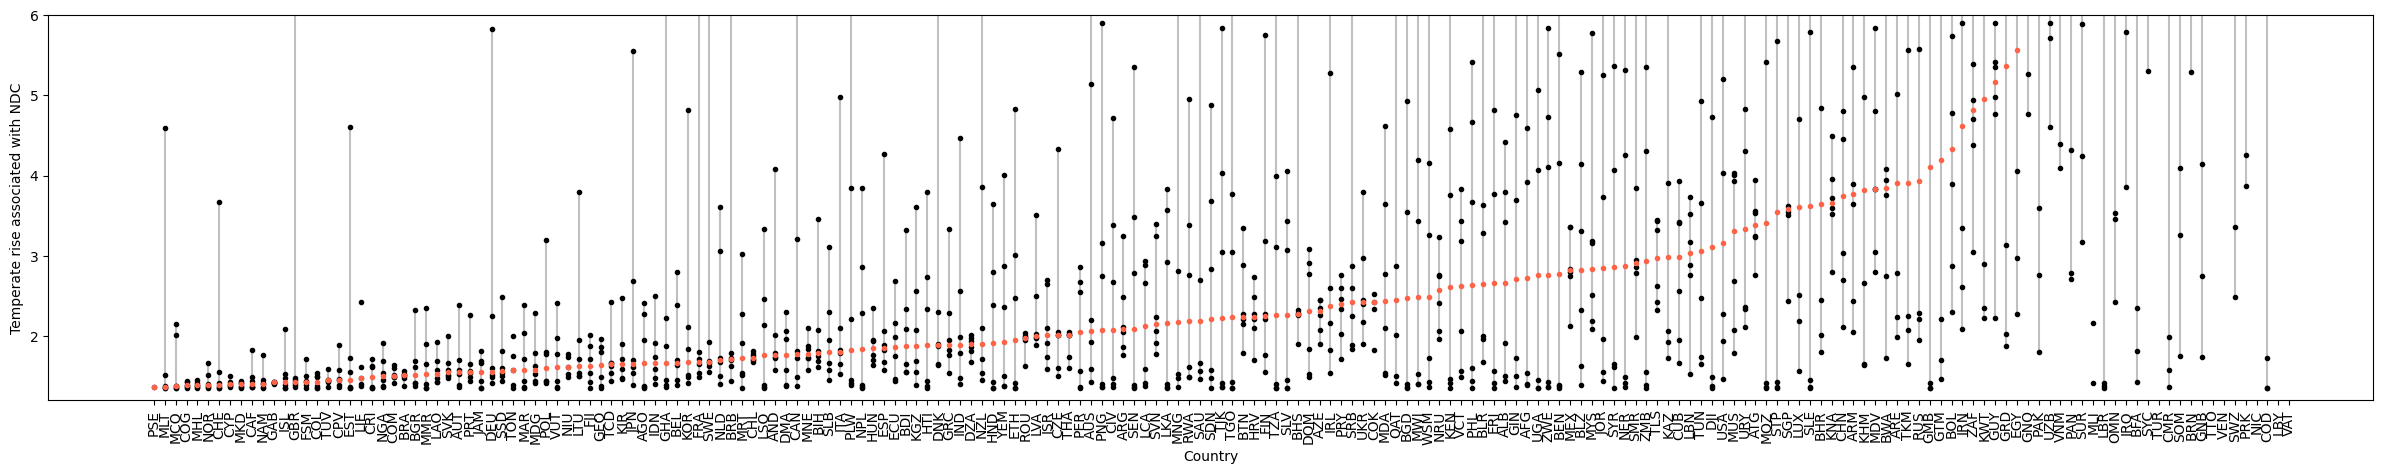

In [ ]:
fig, ax = plt.subplots(figsize=(30, 5))
temperatures_sort_raw = np.zeros(shape=(len(rules), len(all_countries_iso)))
for var_i, var in enumerate(rules):
    temperatures_sort_raw[var_i] = np.copy(temps[var_i])

mean_temperatures = np.nanmedian(temperatures_sort_raw, axis=0)
idx = np.argsort(mean_temperatures)
temperatures_sort = temperatures_sort_raw[:, idx]
cs_sort = all_countries_iso[idx]
ax.plot(cs_sort, np.nanmedian(temperatures_sort, axis=0), '.', c='tomato', zorder=1e9)
for i in range(len(rules)):
    ax.plot(cs_sort, temperatures_sort[i], '.', c='black')
for cty_i, cty in enumerate(cs_sort):
    ax.plot([cty, cty], [np.min(temperatures_sort[:, cty_i]), np.max(temperatures_sort[:, cty_i])], c='silver', zorder=-1e9)

ax.set_ylim([1.2, 6])
ax.set_xlabel("Country") # Colour country by continent, .. etc.
ax.set_ylabel("Temperate rise associated with NDC")
ax.set_xticklabels(cs_sort, rotation = 90)
plt.show()

KeyError: 'Northern America'

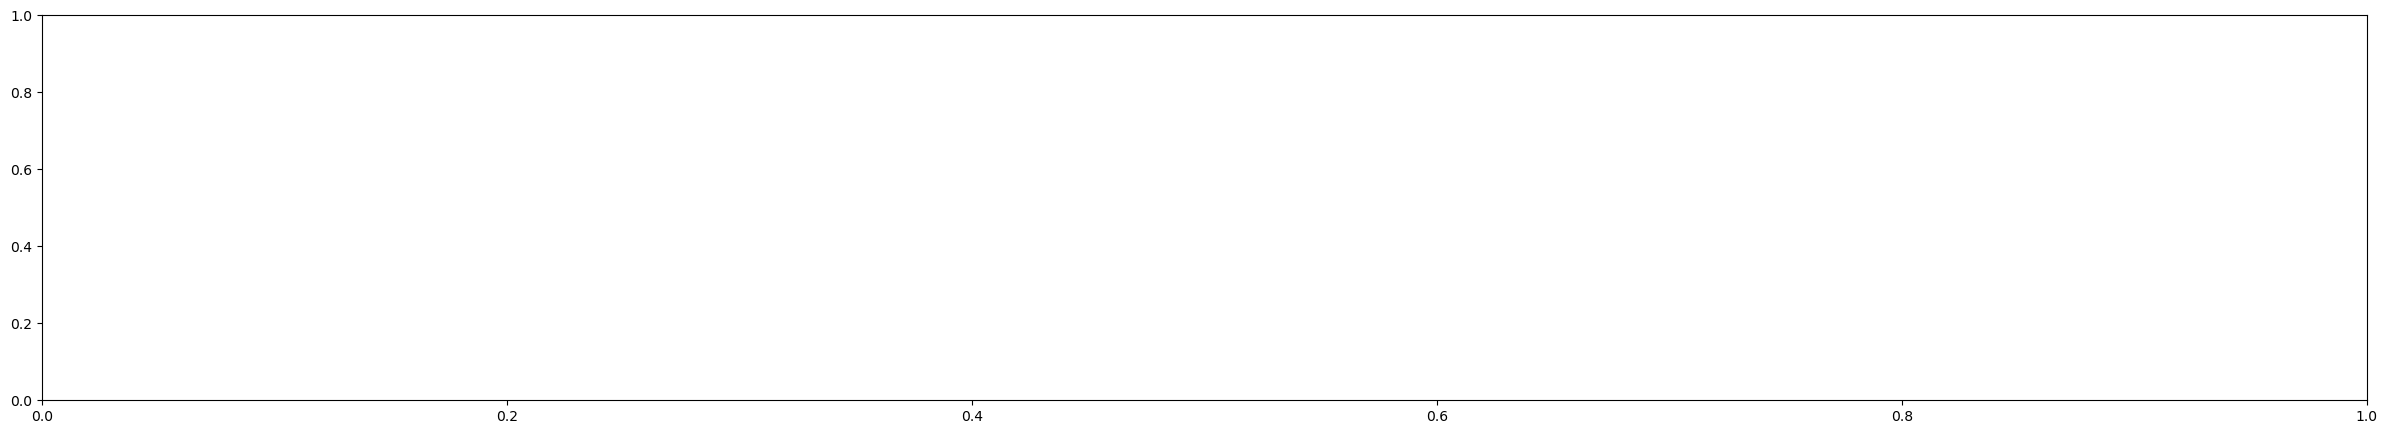

In [ ]:
temperatures_raw = np.zeros(shape=(len(rules), len(all_countries_iso)))
for var_i, var in enumerate(rules):
    temperatures_raw[var_i] = np.copy(temps[var_i])
mean_temperatures = np.nanmedian(temperatures_raw, axis=0)

fig, ax = plt.subplots(figsize=(30, 5))

# Europe
for group_i, group in enumerate(['Northern America', "EU", "African Group", "Australasia", "SIDS"]):
    abbr = ['NA', 'EU', 'AG', "AU", "SIDS"][group_i]
    ax.plot(abbr, np.nanmean(mean_temperatures[np.array(df[group]) == 1]), '.', c='black', zorder=1e9, ms=20)
    ax.plot(countries_iso[np.array(df[group]) == 1], mean_temperatures[np.array(df[group]) == 1], '.', c='tomato', zorder=1e9)
    ax.plot([(' ')*group_i], [0], '.')

# ax.plot(cs_sort, np.nanmedian(temperatures_sort, axis=0), '.', c='tomato', zorder=1e9)
# for i in range(len(rules)):
#     ax.plot(cs_sort, temperatures_sort[i], '.', c='black')
# for cty_i, cty in enumerate(cs_sort):
#     ax.plot([cty, cty], [np.min(temperatures_sort[:, cty_i]), np.max(temperatures_sort[:, cty_i])], c='silver', zorder=-1e9)

ax.set_ylim([1, 10])
ax.set_xlabel("Country") # Colour country by continent, .. etc.
ax.set_ylabel("Temperate rise associated with NDC")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()